In [1]:
import enum
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# cooperate => True
# defect => False

In [3]:
class TypeOfStrategy(enum.Enum):
    Defactor = 1
    Cooperator = 2
    Tit_for_tat = 3
    Anti_tit_for_tat = 4
    
def chr2strategy(strategy):
    if strategy == 'D':
        return TypeOfStrategy.Defactor
    if strategy == 'C':
        return TypeOfStrategy.Cooperator
    if strategy == 'T':
        return TypeOfStrategy.Tit_for_tat
    if strategy == 'A':
        return TypeOfStrategy.Anti_tit_for_tat
    return None

def strategy2chr(strategy):
    if strategy == TypeOfStrategy.Defactor:
        return 'D'
    if strategy == TypeOfStrategy.Cooperator:
        return 'C'
    if strategy == TypeOfStrategy.Tit_for_tat:
        return 'T'
    if strategy == TypeOfStrategy.Anti_tit_for_tat:
        return 'A'
    return None

In [4]:
# strategija bira uz pomoc next_move koju ce vrednost nas igrac dati (tj. da li ce coop ili defect)
class Strategy:    
    
    def __init__(self, type_of_strategy):
        self.type_of_strategy = type_of_strategy
        self.previous_move = None
        
    def next_move(self, previous_enemy_move):        
        if previous_enemy_move == None:
            if self.type_of_strategy == TypeOfStrategy.Cooperator or self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
                self.previous_move = True
                return True
            else:
                self.previous_move = False
                return False
        else:
            if self.type_of_strategy == TypeOfStrategy.Cooperator:
                self.previous_move = True
                return True
            if self.type_of_strategy == TypeOfStrategy.Defactor:
                self.previous_move = False
                return False
            if self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
                self.previous_move = previous_enemy_move
                return previous_enemy_move
            if self.type_of_strategy == TypeOfStrategy.Anti_tit_for_tat:
                self.previous_move = not previous_enemy_move
                return not previous_enemy_move
    
    def __str__(self):
        return f"Stg({strategy2chr(self.type_of_strategy)})"

In [5]:
# vrednosti kao rate_of_senescence i max_score su uvek iste, pa neka budu staticke
class Player:
    rate_of_senescence = 20
    maximum_score = 4
    starting_score = 2
    
    mutation_probability = 0.0
    # mozda neki drugi?
    starting_age = 0
    
    def __init__(self, type_of_strategy):
        self.strategy = Strategy(type_of_strategy)
        self.age = Player.starting_age
        self.score = Player.starting_score
     
    def check_death(self):
        chance_death_old_age = (self.age / Player.rate_of_senescence) - 1  
        # ocemo biramo da jedan umre at a time, ili samo ovako?
        if random.random() < chance_death_old_age or self.score <= 0:
            return True
        return False
    
    def reborn(self, neighbours):
        # moguci ishodi:
        # 1) kopira sve od random suseda
        # 2) mutacija => mala verovatnoca, uzima skroz random strategiju, i pocinje ispocetka
        if random.random() < Player.mutation_probability:
            self.mutation()
        else:
            selected_neighbour = random.choice(neighbours)
            self.strategy = Strategy(selected_neighbour.strategy.type_of_strategy)
            # pitaj andriju, skroz konfuzno
            # self.strategy.previous_move = selected_neighbour.strategy.previous_move
            self.score = selected_neighbour.score
        self.age = 0
            
    def mutation(self):
        # mala sansa da uzme random strategiju
        self.strategy = Strategy(TypeOfStrategy(random.randint(1, len(TypeOfStrategy))))
        self.age = Player.starting_age        
        self.score = Player.starting_score
        
    def __str__(self):
        return f"Ply({self.strategy}, Age({self.age}), Scr({self.score}))"


In [6]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

In [7]:
class Game:
    Cooperate = True
    Defect = False
    
    def __init__(self, payoff_values, n=10, initial_state=None, num_of_iterations=10):
        self.payoff_matrix = self.__set_payoff_matrix(payoff_values)
        self.n = n if initial_state is None else len(initial_state)
        self.state = self.__process_initial_state(n, initial_state)
        self.num_of_iterations = num_of_iterations
        self.strategy_counter = []
     
    def __set_payoff_matrix(self, payoff_values):
        return {
            (Game.Cooperate, Game.Cooperate) : (payoff_values["R"], payoff_values["R"]),
            (Game.Cooperate, Game.Defect) : (payoff_values["S"], payoff_values["T"]),
            (Game.Defect, Game.Cooperate) : (payoff_values["T"], payoff_values["S"]),
            (Game.Defect, Game.Defect) : (payoff_values["P"], payoff_values["P"])
        }
    
    def __process_initial_state(self, n, initial_state):
        state = []
        
        if initial_state is not None:
            state = [[Player(chr2strategy(strategy)) for strategy in row] for row in initial_state]
        else:
            state = [[Player(TypeOfStrategy(random.randint(1, 4))) for _ in range(n)] for _ in range(n)]
        
        return state
    
    def __neighbours(self, i, j):
        neighbours = []
        if i > 0 and j > 0:
            neighbours.append(self.state[i-1][j-1])
        if i > 0:
            neighbours.append(self.state[i-1][j])
        if i > 0 and j < self.n - 1:
            neighbours.append(self.state[i-1][j+1])
        if j > 0:
            neighbours.append(self.state[i][j-1])
        if j < self.n - 1:
            neighbours.append(self.state[i][j+1])
        if i < self.n - 1 and j > 0:
            neighbours.append(self.state[i+1][j-1])
        if i < self.n - 1:
            neighbours.append(self.state[i+1][j])
        if i < self.n - 1 and j < self.n - 1:
            neighbours.append(self.state[i+1][j+1])
        return neighbours
    
    def __select_neighbour_index(self, i, j):
        indices = []
        if i > 0 and j > 0:
            indices.append((i-1, j-1))
        if i > 0:
            indices.append((i-1, j))
        if i > 0 and j < self.n - 1:
            indices.append((i-1, j+1))
        if j > 0:
            indices.append((i, j-1))
        if j < self.n - 1:
            indices.append((i, j+1))
        if i < self.n - 1 and j > 0:
            indices.append((i+1, j-1))
        if i < self.n - 1:
            indices.append((i+1, j))
        if i < self.n - 1 and j < self.n - 1:
            indices.append((i+1, j+1))
            
        index = random.randint(0, len(indices) - 1)
        
        return indices[index]
    
    def __players_interations(self, player1, player2, neighbours1, neighbours2):
        p1_move = player1.strategy.next_move(player2.strategy.previous_move)
        p2_move = player2.strategy.next_move(player1.strategy.previous_move)    
        #print(f'Moves: {p1_move}, {p2_move}')
        p1_payoff_value, p2_payoff_value = self.payoff_matrix[(p1_move, p2_move)]
    
        #print(f'Payoff: {p1_payoff_value}, {p2_payoff_value}')
        player1.score += p1_payoff_value
        player2.score += p2_payoff_value
    
        if player1.check_death():
            player1.reborn(neighbours1)
        if player2.check_death():
            player2.reborn(neighbours2)
    
    def play_game(self):
        
        for iteration in range(self.num_of_iterations):
            print(f"Iterations #: {iteration + 1}")
            self.print_strategy_matrix()
            self.print_score_matrix()
            
            self.strategy_counter.append(
                {
                    TypeOfStrategy.Cooperator: self.count_stategy(TypeOfStrategy.Cooperator), 
                    TypeOfStrategy.Defactor: self.count_stategy(TypeOfStrategy.Defactor),
                    TypeOfStrategy.Tit_for_tat: self.count_stategy(TypeOfStrategy.Tit_for_tat),
                    TypeOfStrategy.Anti_tit_for_tat: self.count_stategy(TypeOfStrategy.Anti_tit_for_tat)
                }
            )
            
            print(self.strategy_counter[-1])
                                          
            # Update game
            for i in range(self.n):
                for j in range(self.n):
                    #print(f'Player: {i}, {j}')
                    player1 = self.state[i][j]
                    neighbours1 = self.__neighbours(i, j)
                    
                    (neighbour_i, neighbour_j) = self.__select_neighbour_index(i, j)
                    player2 = self.state[neighbour_i][neighbour_j]
                    neighbours2 = self.__neighbours(neighbour_i, neighbour_j)
                    
                    self.__players_interations(player1, player2, neighbours1, neighbours2)
                    player1.age += 1
                    
        return 
    
    def num_of_players(self):
        return self.n * self.n
                    
    def count_stategy(self, target_strategy):
        return [strategy for row in self.strategy_matrix() for strategy in row].count(target_strategy)
    
    def strategy_matrix(self):
        return [[player.strategy.type_of_strategy for player in row] for row in self.state]
    
    def print_strategy_matrix(self):
        print("\n".join([" ".join([strategy2chr(player.strategy.type_of_strategy) for player in row]) for row in self.state]))
    
    def age_matrix(self):
        return [[player.age for player in row] for row in self.state]
    
    def print_age_matrix(self):
        print("\n".join([" ".join([f'{player.age:2}' for player in row]) for row in self.state]))
    
    def score_matrix(self):
        return [[player.score for player in row] for row in self.state]
        
    def print_score_matrix(self):
        print("\n".join([" ".join([f'{player.score:2}' for player in row]) for row in self.state]))
        
    def __str__(self):
        return "\n".join(["; ".join([str(player) for player in row]) for row in self.state])


In [8]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state = [
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D']
]

game = Game(payoff_values, n=7, initial_state=initial_state, num_of_iterations=50)
game.play_game()

print("Final State:")
print("Strategies:")
game.print_strategy_matrix()
print("Ages:")
game.print_age_matrix()
print("Score:")
game.print_score_matrix()

Iterations #: 1
D D D D D D D
D D D T T T D
D D D T T T D
D D D D D D D
D D T T T D D
D D T T T D D
D D D D D D D
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 37, <TypeOfStrategy.Tit_for_tat: 3>: 12, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 2
D D D D D D D
D D D T T T D
D D D T T T D
D D D D D D D
D D T T T D D
D D T T T D D
D D D D D D D
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  4  2  2
 2  2  2  5  3  2  2
 2  2  2  2  2  2  2
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 37, <TypeOfStrategy.Tit_for_tat: 3>: 12, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 3
D D D D D D D
D D D T T T D
D D D T T T D
D D D D D D D
D D T T T D D
D D T T T D D
D D D D D D D
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2  2  2  2  2  2
 2  2

In [9]:
def plot_strategy_ratio(game):
    
    X = np.linspace(0, 1, num=game.num_of_iterations)
    
    coop_count = np.array([count[TypeOfStrategy.Cooperator] / game.num_of_players() for count in game.strategy_counter])
    def_count = np.array([count[TypeOfStrategy.Defactor] / game.num_of_players() for count in game.strategy_counter])
    tft_count = np.array([count[TypeOfStrategy.Tit_for_tat] / game.num_of_players() for count in game.strategy_counter])
    atft_count = np.array([count[TypeOfStrategy.Anti_tit_for_tat] / game.num_of_players() for count in game.strategy_counter])

    Y1 = np.ones(game.num_of_iterations)
    Y2 = coop_count + def_count + tft_count
    Y3 = coop_count + def_count
    Y4 = coop_count
    Y5 = np.zeros(game.num_of_iterations)
    
    plt.plot(X, Y1, color='white')
    plt.fill_between(X, Y1, color='red', label='ATFT')
    plt.plot(X, Y2, color='white')
    plt.fill_between(X, Y2, color='blue', label='TFT')
    plt.plot(X, Y3, color='white')
    plt.fill_between(X, Y3, color='green', label='DEF')
    plt.plot(X, Y4, color='white')
    plt.fill_between(X, Y4, color='yellow', label='COOP')
    plt.plot(X, Y5, color='white')
    
    plt.legend(loc='lower left')
    plt.show()

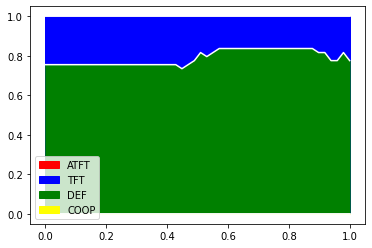

In [14]:
plot_strategy_ratio(game)

In [15]:
initial_state = [
    ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],    
    ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],
    ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],
    ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],
    ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
]

game = Game(payoff_values, n=10, initial_state=initial_state, num_of_iterations=100)
game.play_game()


Iterations #: 1
C C C C C C C C C C
C C C C C C C C C C
C C C C C C C C C C
C C C C C C C C C C
C C C C C C C C C C
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
{<TypeOfStrategy.Cooperator: 2>: 50, <TypeOfStrategy.Defactor: 1>: 50, <TypeOfStrategy.Tit_for_tat: 3>: 0, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 2
C C C C C C C C C C
C C C C C C C C C C
C C C C C C C C C C
C C C C C C C C C C
C C C C C C C C C D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
D D D D D D D D D D
 4  3  4  7  3  4  4  4  3  4
 3  5  4  5  4  3  4  5  5  4
 3  4  4  4  3  3  3  6  4  3
 4  4  5  3  4  4  6  3  3  4


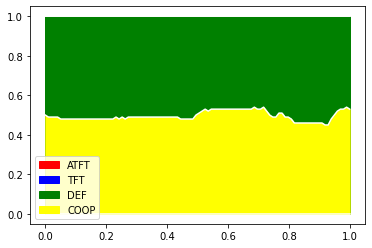

In [16]:
plot_strategy_ratio(game)

In [17]:
initial_state = [
    ['T' if random.random() < 0.5 else 'D' for _ in range(10)]
    for _ in range(10)
]

game = Game(payoff_values, n=10, initial_state=initial_state, num_of_iterations=100)
game.play_game()

Iterations #: 1
D D T T D T D T T T
T T D T T T T T T D
T T T D D T D D T T
D T D D D D T T T T
D D D T D D T T T T
T T D D D T D T D T
D T D D T T T D D D
T T T D T D D T D T
T D D D D D D T D D
D D D D T T T T T T
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2
{<TypeOfStrategy.Cooperator: 2>: 0, <TypeOfStrategy.Defactor: 1>: 47, <TypeOfStrategy.Tit_for_tat: 3>: 53, <TypeOfStrategy.Anti_tit_for_tat: 4>: 0}
Iterations #: 2
D D T T D T D T T T
T T D T T T T T T D
T T T D D T D D T T
D T D D D D T T T T
D D D T D D T T T T
T T D D D T D T D T
D T D D T T T D D D
T T T D T D D T D T
T D D D D D D T D D
D D D D T T T T T T
 2  2  2  3  2  2  2  2  2  3
 3  2  2  3  2  3  5  4  4  2
 2  4  2  2  2  2  2  2  2  5
 2  3  2  2  2  2  2  2  3  5


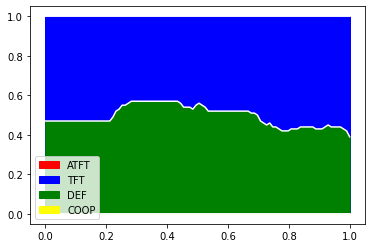

In [18]:
plot_strategy_ratio(game)